<a href="https://colab.research.google.com/github/7PAM2015-0509-2023-Group-20/Kaggle-Challenge-20/blob/main/Group_project_Kaggle_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install h2o

Importing libraries

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


Importing libraries for H2O AutoML and NetworkX

In [30]:
import h2o
from h2o.automl import H2OAutoML
import networkx as nx

In [31]:
# Set styles
sns.set(style="whitegrid", font_scale=1.2)
pd.set_option("display.max_columns", None)

Load datasets

In [32]:
train_data = pd.read_csv("https://raw.githubusercontent.com/7PAM2015-0509-2023-Group-20/Kaggle-Challenge-20/main/train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/7PAM2015-0509-2023-Group-20/Kaggle-Challenge-20/main/test.csv")

EDA

In [33]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (8693, 14)
Test dataset shape: (4277, 13)


In [34]:
print(f"Duplicate rows in train dataset: {train_data.duplicated().sum()}")
print(f"Duplicate rows in test dataset: {test_data.duplicated().sum()}")

Duplicate rows in train dataset: 0
Duplicate rows in test dataset: 0


In [35]:
print("Data types in training data:")
print(train_data.dtypes)

Data types in training data:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [36]:
print("Data types in testing data:")
print(test_data.dtypes)

Data types in testing data:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object


Handle missing values

In [37]:
missing_train = train_data.isnull().sum()[train_data.isnull().sum() > 0]
missing_test = test_data.isnull().sum()[test_data.isnull().sum() > 0]
print("Missing values in train data:")
print(missing_train)
print("Missing values in test data:")
print(missing_test)

Missing values in train data:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64
Missing values in test data:
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Feature engineering

In [38]:
def create_new_features(df):
    # PassengerId-based features
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    df['Member'] = df['PassengerId'].apply(lambda x: x.split('_')[1])
    df['Solo_Travel'] = df['Group'].map(df['Group'].value_counts()) == 1
    df['Group_Size'] = df['Group'].map(df['Group'].value_counts())

    # Cabin-based features
    df['Cabin'].fillna('nan/nan/nan', inplace=True)
    df['Cabin_Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
    df['Cabin_Num'] = df['Cabin'].apply(lambda x: x.split('/')[1])
    df['Cabin_Side'] = df['Cabin'].apply(lambda x: x.split('/')[2])
    df[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']] = df[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']].replace('nan', np.nan)
    df['Cabin_Deck'].fillna(df['Cabin_Deck'].mode()[0], inplace=True)
    df['Cabin_Side'].fillna(df['Cabin_Side'].mode()[0], inplace=True)
    df['Cabin_Num'] = df['Cabin_Num'].astype(float).fillna(df['Cabin_Num'].median())

    df['Cabin_Region'] = pd.cut(df['Cabin_Num'], bins=[0, 300, 600, 900, 1200, 1500, np.inf], labels=[1, 2, 3, 4, 5, 6])

    # Age-based features
    df['Age_Group'] = pd.cut(df['Age'], bins=[-np.inf, 12, 18, 25, 32, 50, np.inf], labels=['0-12', '13-18', '19-25', '26-32', '33-50', '50+'])

    # Expenditure features
    df['Total_Expenditure'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    df['No_Spending'] = df['Total_Expenditure'] == 0

In [39]:
create_new_features(train_data)
create_new_features(test_data)

Fill missing values

In [40]:
cat_features = train_data.select_dtypes(include=['object', 'bool']).columns.to_list()
num_features = train_data.select_dtypes(include=['int', 'float']).columns.to_list()
cat_features.remove('Transported')

Imputing values

In [41]:
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='median')

train_data[cat_features] = imputer_cat.fit_transform(train_data[cat_features])
train_data[num_features] = imputer_num.fit_transform(train_data[num_features])

test_data[cat_features] = imputer_cat.transform(test_data[cat_features])
test_data[num_features] = imputer_num.transform(test_data[num_features])

In [42]:
train_df = train_data.copy()
test_df = test_data.copy()

Drop unnecessary columns

In [43]:
passenger_id = test_data['PassengerId']
train_data.drop(columns=['PassengerId', 'Name', 'Cabin'], inplace=True)
test_data.drop(columns=['PassengerId', 'Name', 'Cabin'], inplace=True)

Log transformation

In [44]:
for feature in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    train_data[feature] = np.log1p(train_data[feature])
    test_data[feature] = np.log1p(test_data[feature])

Convert boolean features

In [45]:
bool_features = ['CryoSleep', 'VIP', 'Solo_Travel', 'No_Spending', 'Cabin_Region']
train_data[bool_features] = train_data[bool_features].astype(bool)
test_data[bool_features] = test_data[bool_features].astype(bool)

**Visual representation of the datasets(EDA)**

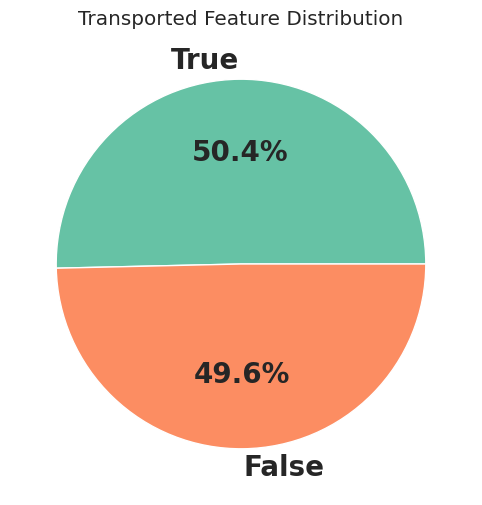

In [46]:
plt.figure(figsize=(10,6))
plt.pie(train_data["Transported"].value_counts(),labels=train_data["Transported"].value_counts().keys(),autopct="%1.1f%%",
       textprops={"fontsize":20,"fontweight":"black"},colors=sns.color_palette("Set2"))
plt.title("Transported Feature Distribution");

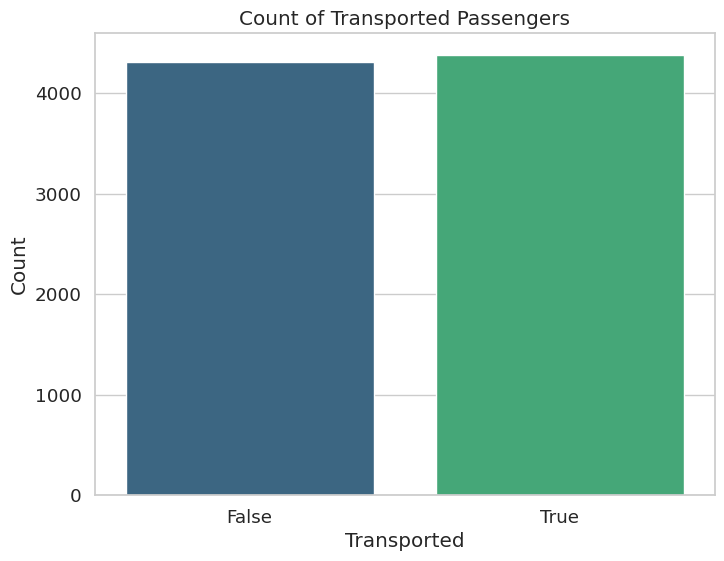

In [47]:
# EDA Visualizations

# 1. Count plot of 'Transported'
plt.figure(figsize=(8, 6))
sns.countplot(x='Transported', data=train_data, palette='viridis')
plt.title('Count of Transported Passengers')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()


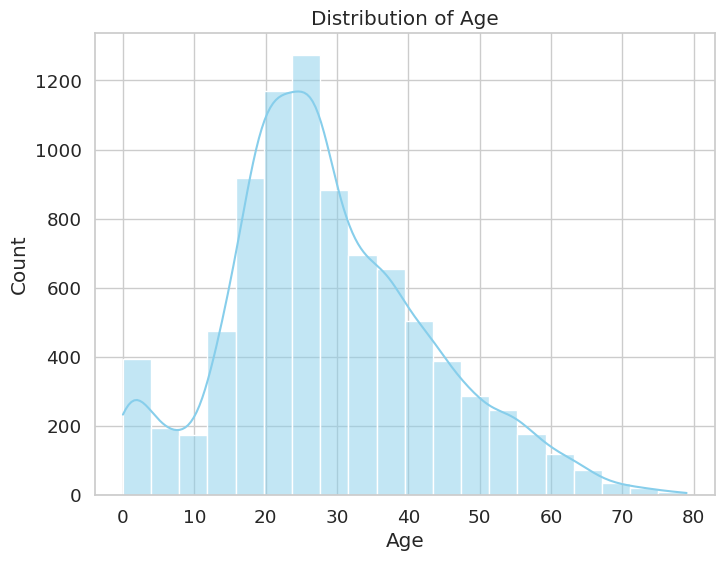

In [48]:
# 2. Distribution of 'Age'
plt.figure(figsize=(8, 6))
sns.histplot(train_data['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


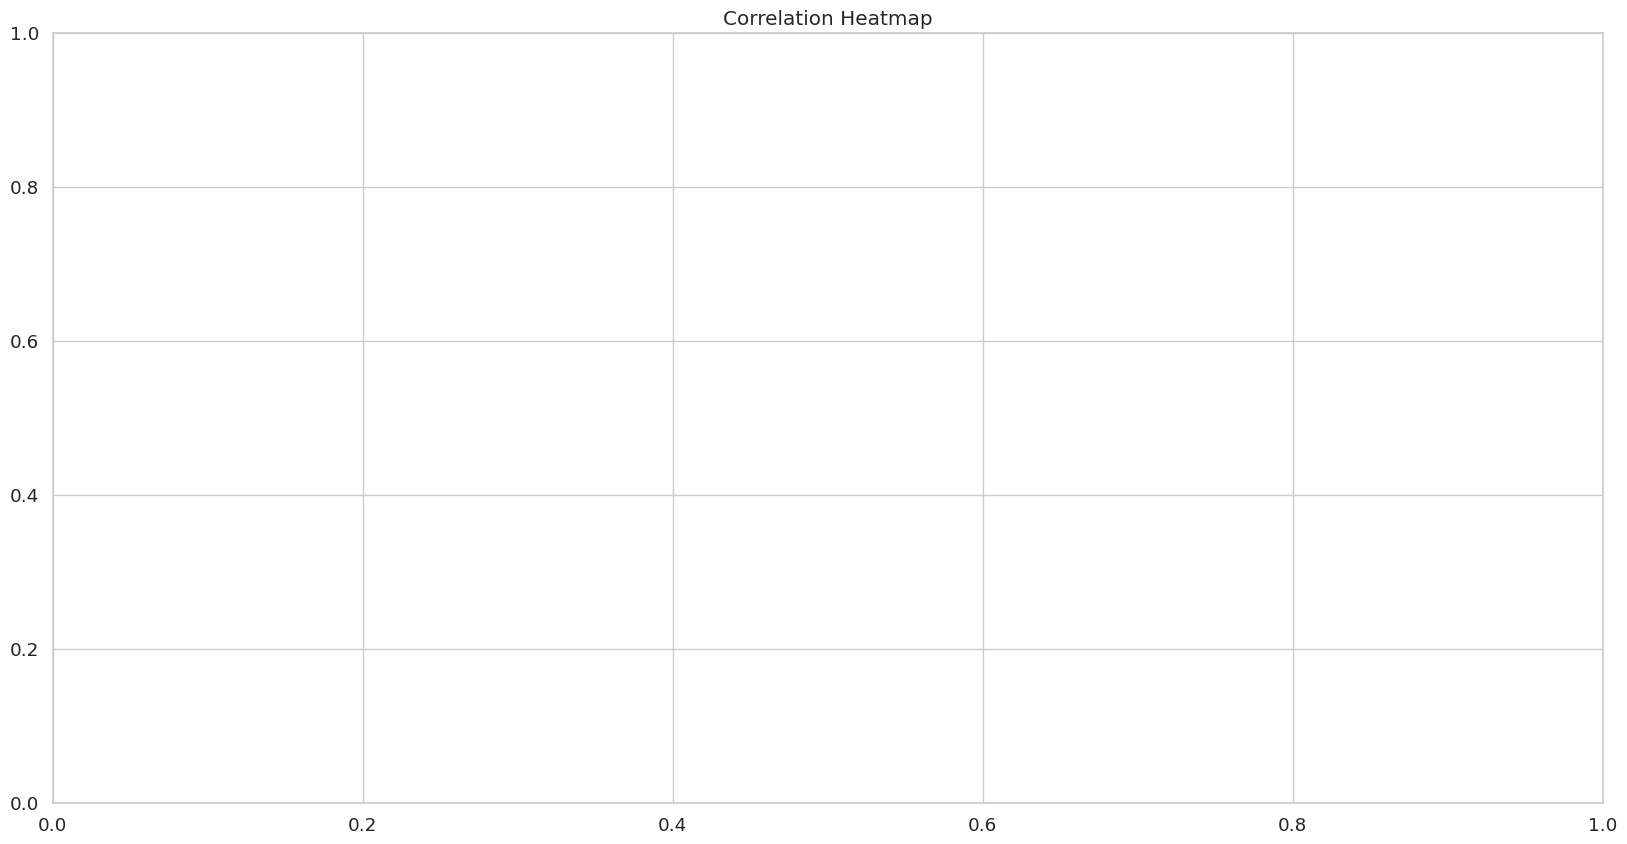

In [55]:
# 5. Correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

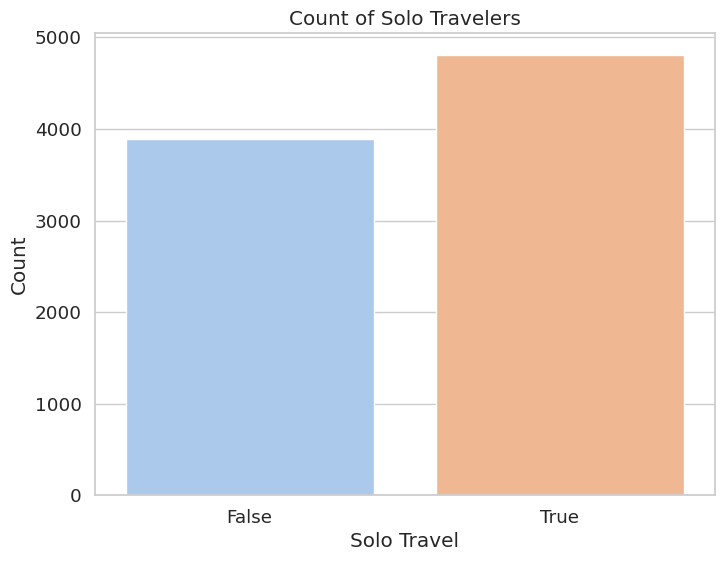

In [52]:
# Count plot of 'Solo_Travel'
plt.figure(figsize=(8, 6))
sns.countplot(x='Solo_Travel', data=train_data, palette='pastel')
plt.title('Count of Solo Travelers')
plt.xlabel('Solo Travel')
plt.ylabel('Count')
plt.show()

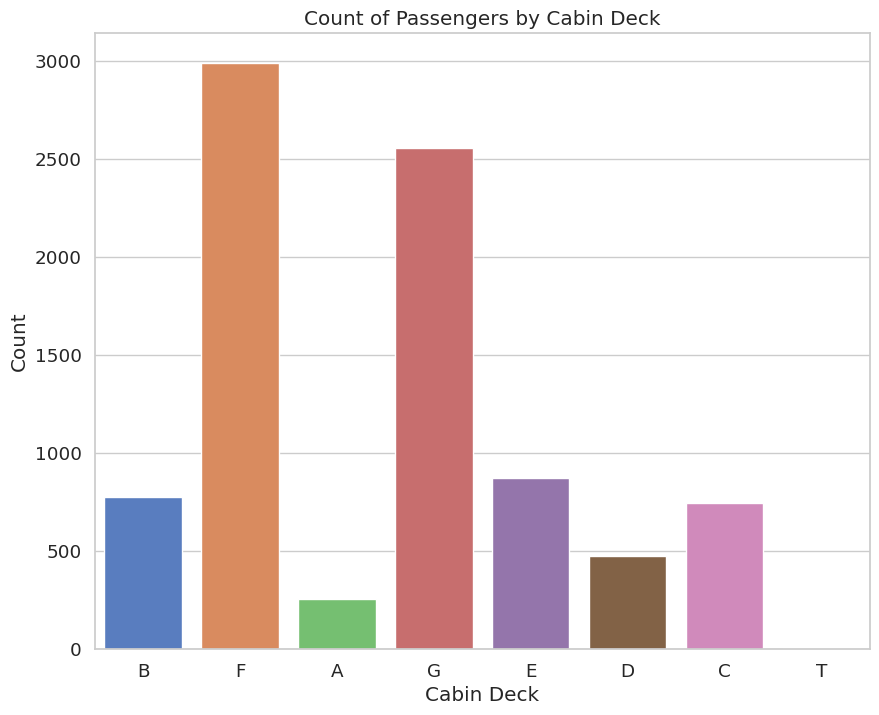

In [53]:
# Bar plot of 'Cabin_Deck'
plt.figure(figsize=(10, 8))
sns.countplot(x='Cabin_Deck', data=train_data, palette='muted')
plt.title('Count of Passengers by Cabin Deck')
plt.xlabel('Cabin Deck')
plt.ylabel('Count')
plt.show()

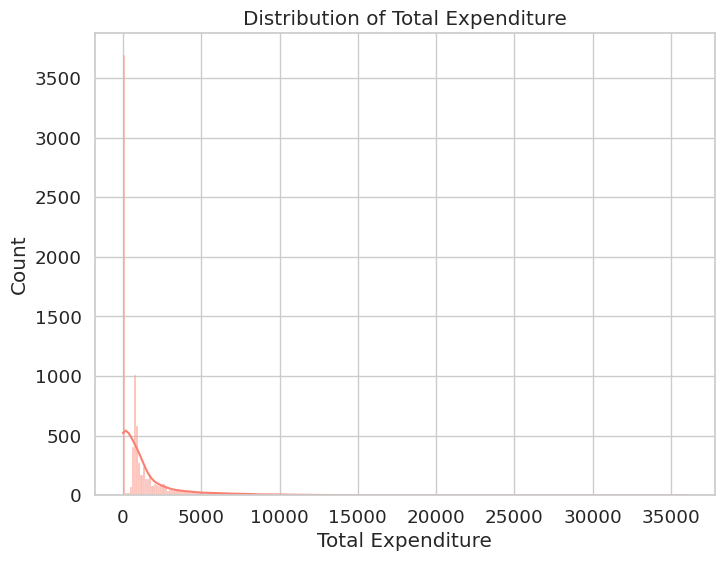

In [54]:
# Distribution plot of 'Total_Expenditure'
plt.figure(figsize=(8, 6))
sns.histplot(train_data['Total_Expenditure'], kde=True, color='salmon')
plt.title('Distribution of Total Expenditure')
plt.xlabel('Total Expenditure')
plt.ylabel('Count')
plt.show()

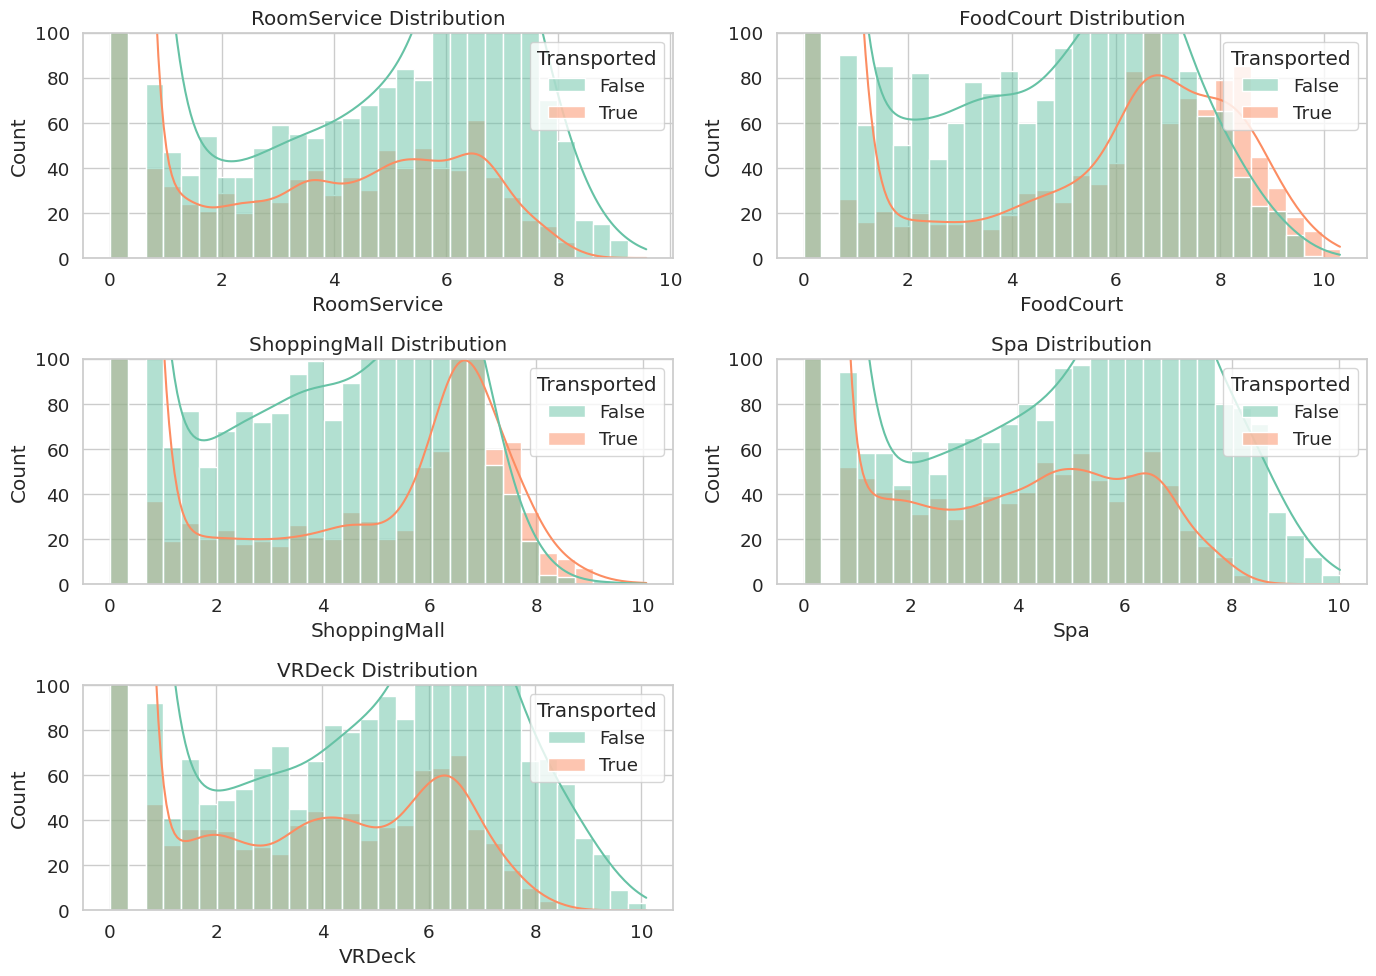

In [56]:
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="Transported", data=train_data,bins=30,kde=True,palette="Set2")
    plt.title(f"{column} Distribution")
    plt.ylim(0,100)
    plt.tight_layout()

Text(0.5, 1.0, 'Group_Size vs Transported')

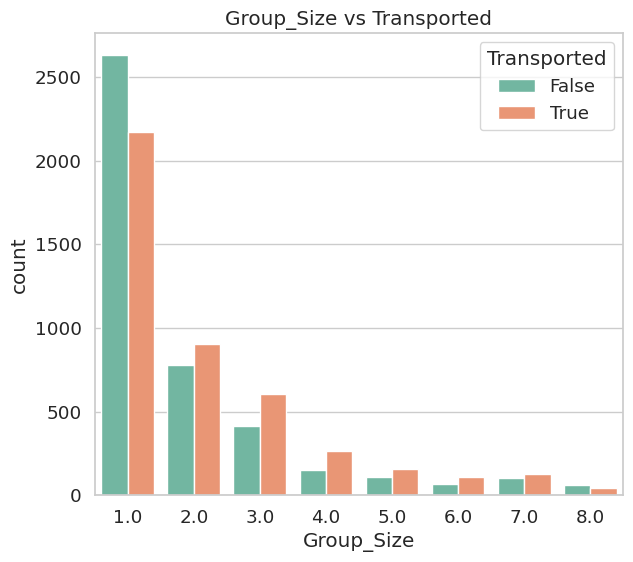

In [57]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x="Group_Size", hue="Transported", data=train_data,palette="Set2")
plt.title("Group_Size vs Transported")

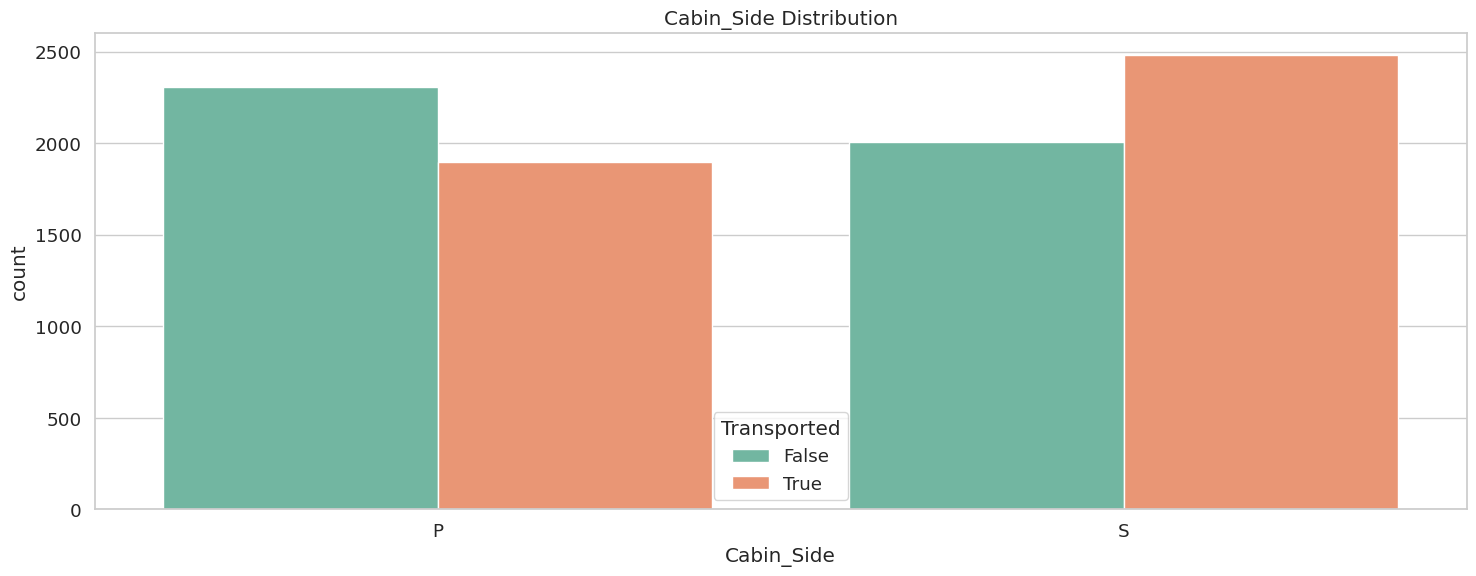

In [58]:
plt.figure(figsize=(15,6))
sns.countplot(x="Cabin_Side", hue="Transported", data=train_data, palette="Set2")
plt.title("Cabin_Side Distribution")
plt.tight_layout()
plt.show()